## Expected Batting Average

### About

- This project aims to replicate the MLB statcast advanced stat "xBA"

### Goals

1) Use supervised ML to predict whether a batted ball is a hit ot an out based on:
    - Pitch velo
    - Exit velo
    - Launch angle
    - Hit location
    - Hit distance (in case HRs aren't given their own hit location?)
    - Batter speed (maybe)
    
2) Find the *expected* batting average for a batter given the above parameters for each batted ball in play 

3) Compare results with statcast's xBA results

### Data

- Data gathered from baseball savant (statcast) search
- Example search query to get all (?) batted balls resulting in outs in 2018 
    - https://baseballsavant.mlb.com/statcast_search?hfPT=&hfAB=single%7Cdouble%7Ctriple%7Chome%5C.%5C.run%7Cfield%5C.%5C.out%7Cstrikeout%7Cstrikeout%5C.%5C.double%5C.%5C.play%7Cdouble%5C.%5C.play%7Cgrounded%5C.%5C.into%5C.%5C.double%5C.%5C.play%7Cfielders%5C.%5C.choice%7Cfielders%5C.%5C.choice%5C.%5C.out%7Cforce%5C.%5C.out%7Csac%5C.%5C.bunt%7Csac%5C.%5C.bunt%5C.%5C.double%5C.%5C.play%7Csac%5C.%5C.fly%7Csac%5C.%5C.fly%5C.%5C.double%5C.%5C.play%7Ctriple%5C.%5C.play%7C&hfBBT=&hfPR=&hfZ=&stadium=&hfBBL=&hfNewZones=&hfGT=R%7C&hfC=&hfSea=2018%7C&hfSit=&player_type=batter&hfOuts=&opponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfInfield=&team=&position=&hfOutfield=&hfRO=&home_road=&hfFlag=&hfPull=&metric_1=&hfInn=&min_pitches=0&min_results=0&group_by=name&sort_col=pitches&player_event_sort=h_launch_speed&sort_order=desc&min_pas=0#results
    - seems like this returns a maximum of 40,000 results
- Data reference
    - https://baseballsavant.mlb.com/csv-docs

### Notes

- My plan is to use 2018 results in the training/test sets to determine 2019 xBA results
    - Need to think more about if this is the right strategy
- Is it possible to get spray chart info for this?
- Having hc_x and hc_y as two separate features doesn't really tell us much, we need the combination of the two as a vector:
    - $ hc = \sqrt{hc_y^2 + hc_x^2} \tan(y/x) $
    - ATTN: getting weird values here, need to plot to see if it makes sense

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import neighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from confusion import plot_confusion_matrix
import seaborn as sns
from IPython.display import display, clear_output
%matplotlib inline

# field_hits = ['single', 'double', 'triple']
# # any ball hit in play that counts as an AB bit isn't a hit
# field_outs = [
#     'field_out', 'force_out', 'grounded_into_double_play',
#     'double_play', 'field_error', 'fielders_choice', 'fielders_choice_out',
#     'triple_play'
# ]
# sacs = ['sac_fly', 'sac_bunt', 'sac_bunt_double_play', 'sac_fly_double_play']
# Ks = ['strikeout', 'strikeout_double_play']

hits = ['single', 'double', 'triple', 'home_run']
outs_AB = [  
    'strikeout', 'field_out', 'grounded_into_double_play', 'force_out',
    'double_play', 'field_error', 'fielders_choice', 'fielders_choice_out',
    'batter_interference', 'strikeout_double_play', 'triple_play'
] # outs that count as an at bat

def spray_angle(df):
    '''
        Calculate spray angle from hc_x and hc_y in statcast csv output
    '''
    # make home plate (0,0)
    hc_x = df['hc_x'] - 125.42
    hc_y = 198.27 - df['hc_y']
    df['spray_angle'] = np.arctan(hc_x/hc_y)
    df.loc[df['stand'] == 'L', 'spray_angle'] = -df.loc[df['stand'] == 'L', 'spray_angle']
    # convert to degrees
    df['spray_angle'] = df['spray_angle'].apply(np.rad2deg)
    return(df)

def pre_process(data):
    '''
          Process dataframe for KNN, break df into features and results
    '''
    # define features
    features = [
        'launch_speed', 'launch_angle', 'spray_angle'
    ]
    # copy to new dataframe
    df = data.copy()
    df = df[df.events.isin([*hits, *outs_AB])]
    # add outcome column (0: out_AB, 1: hit)
    df['outcome'] = 'out'
    df.loc[df.events.isin(hits), 'outcome'] = 'hit'
    # calculate spray angle from hc_x and hc_y
    df = spray_angle(df)
    # set launch/spray angle/speed = 0 for strikeouts
    # these events count for *most* of the NaN values here
    # check with > df.loc[df.launch_speed.isnull(), 'events'].value_counts()
    df.loc[df.events.isin(['strikeout', 'strikeout_double_play']), [*features, 'hc_x', 'hc_y']] = 0
    # drop remaining rows with NaN
    df.dropna(inplace=True)
    # break into features (X) and outcomes (y)
    X, y = df[features], df['outcome']
    return(X, y, df)

def calc_BA(data):
    hits_total = len(data.loc[data['events'].isin(hits)])
    outs_total = len(data.loc[data['events'].isin(outs_AB)])
    return(hits_total/(hits_total + outs_total))

    
# import and pre-process the data
data = pd.read_csv('data/all_outcomes_2018.csv')
X, y, df = pre_process(data)

In [4]:
df.events.value_counts()

field_out                    72275
strikeout                    39953
single                       25852
double                        8108
home_run                      5376
force_out                     3523
grounded_into_double_play     3395
field_error                   1553
triple                         830
double_play                    445
fielders_choice_out            324
strikeout_double_play          155
fielders_choice                 91
triple_play                      2
Name: events, dtype: int64

## Exploring the dataset

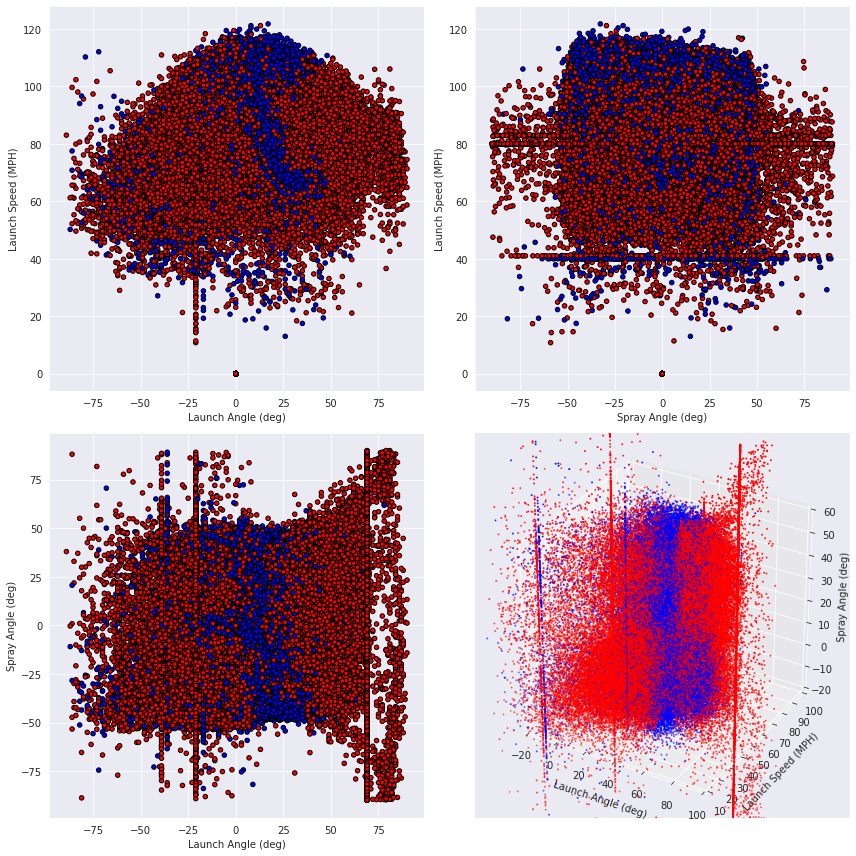

In [5]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# plot outs as red, hits as blue
colors = pd.DataFrame(y.copy())
colors['colors'] = 'red'
colors.loc[colors['outcome'] == 'hit', 'colors'] = 'blue'
colors = np.array(colors['colors'])

# launch angle vs. launch speed
ax[0,0].scatter(X['launch_angle'], X['launch_speed'], s=20, c=colors, edgecolors='black', linewidth=1)
ax[0,0].set_xlabel('Launch Angle (deg)')
ax[0,0].set_ylabel('Launch Speed (MPH)')

# spray angle vs. launch speed
ax[0,1].scatter(X['spray_angle'], X['launch_speed'], s=20, c=colors, edgecolors='black', linewidth=1)
ax[0,1].set_xlabel('Spray Angle (deg)')
ax[0,1].set_ylabel('Launch Speed (MPH)')

# spray angle vs. launch speed
ax[1,0].scatter(X['launch_angle'], X['spray_angle'],  s=20, c=colors, edgecolors='black', linewidth=1)
ax[1,0].set_xlabel('Launch Angle (deg)')
ax[1,0].set_ylabel('Spray Angle (deg)')

# 3D plot of all features
for val in ['top', 'bottom', 'left', 'right']:
    ax[1,1].spines[val].set_visible(False)
ax[1,1].tick_params(
    axis='x', which='both',
    top=False, bottom=False
)
ax[1,1].tick_params(
    axis='y', which='both',
    left=False, right=False
)
ax[1,1].set_yticklabels('')
ax[1,1].set_xticklabels('')
ax = fig.add_subplot(224, projection='3d')

ax.scatter(
    X['launch_angle'], X['launch_speed'], X['spray_angle'],
    c=colors, s=1,
)
ax.set_ylim([10, 100])
ax.set_xlim([-20, 100])
ax.set_zlim([-20, 60])

ax.set_ylabel('Launch Speed (MPH)')
ax.set_xlabel('Launch Angle (deg)')
ax.set_zlabel('Spray Angle (deg)')
fig.tight_layout()
plt.show()
fig.savefig('feature_exploration.png', dpi=300)

#### Notes

- There seems to be some spurious data here
    - groups with constant launch angle and speed for various spray angles...

In [6]:
data[data['launch_speed'] == 80.0].head()

,events,description,batter,stand,launch_angle,launch_speed,hc_x,hc_y,pitcher,p_throws,pitch_type,release_speed,release_spin_rate
63,field_out,hit_into_play,571448.0,R,69.0,80.0,169.98,202.90,621111.0,R,SL,85.9,3117.0
76,field_out,hit_into_play,456124.0,R,69.0,80.0,151.94,191.82,448802.0,L,FF,89.1,2439.0
176,field_out,hit_into_play,571851.0,R,69.0,80.0,188.90,159.11,542881.0,L,FF,92.1,2377.0
185,field_out,hit_into_play,543685.0,R,69.0,80.0,155.59,157.29,542881.0,L,CH,81.5,1746.0
193,field_out,hit_into_play,645302.0,R,69.0,80.0,160.44,188.79,542881.0,L,CH,79.6,1990.0


- There are a ton of data points with LA = 69.0 and LS = 80.0 that are outs
    - This is just a common weak pop up I think?
- Launch speed of 40 mph could be bunts?
    - In spray_angle vs. launch_speed there are two rows with contant launch_speed=40mph 
        - One row could be successful bunts and the others bunts for outs
    - Yup, I checked in baseball savant and bunts are around 40 mph exit velocity
- Going to move forward for now, but need to think about the other "spurious" groups

## Creating the Model

Accuracy of KNN classifier on training set: 0.88
Accuracy of KNN classifier on test set: 0.88

Expected Batting Average for Dee Gordon: 0.196
Actual Batting Average: 0.281


Expected Batting Average for Edwin Encarnacion: 0.234
Actual Batting Average: 0.241

Normalized confusion matrix
[[0.64285714 0.35714286]
 [0.01886792 0.98113208]]
Normalized confusion matrix
[[0.80392157 0.19607843]
 [0.04545455 0.95454545]]


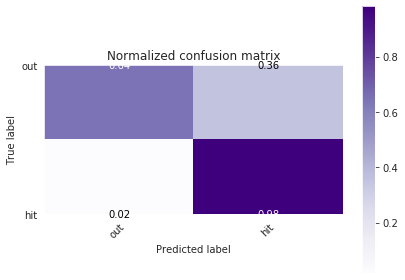

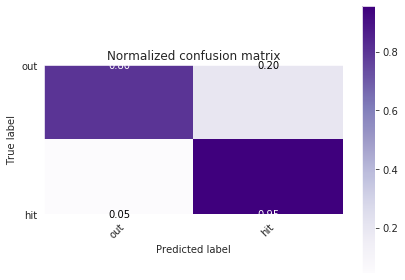

In [7]:
# split up data into train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 0
)

# K-Nearest Neighbors 
nn = 106
clf = neighbors.KNeighborsClassifier(nn)
clf.fit(X, y)

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

# calculate expected batting average for a couple players
dee = pd.read_csv('data/dee_gordon_2019.csv')
edwin = pd.read_csv('data/edwin_encarnacion.csv')

X_dee, y_dee, df_dee = pre_process(dee)
X_edwin, y_edwin, df_edwin = pre_process(edwin)

predicted_outcomes_dee = clf.predict(X_dee)
unique, counts = np.unique(predicted_outcomes_dee, return_counts=True)
d = dict(zip(unique, counts))
xBA_dee = d['hit']/(d['out'] + d['hit'])

predicted_outcomes_edwin = clf.predict(X_edwin)
unique, counts = np.unique(predicted_outcomes_edwin, return_counts=True)
d = dict(zip(unique, counts))
xBA_edwin = d['hit']/(d['out'] + d['hit'])

BA_dee = calc_BA(dee)
BA_edwin = calc_BA(edwin)

print('\nExpected Batting Average for Dee Gordon: {:.3f}'.format(xBA_dee))
print('Actual Batting Average: {:.3f}\n'.format(BA_dee))
print('\nExpected Batting Average for Edwin Encarnacion: {:.3f}'.format(xBA_edwin))
print('Actual Batting Average: {:.3f}\n'.format(BA_edwin))

sns.set_style('dark')
plot_confusion_matrix(y_dee, predicted_outcomes_dee, ['out', 'hit'], normalize=True)
plot_confusion_matrix(y_edwin, predicted_outcomes_edwin, ['out', 'hit'], normalize=True)
plt.show()

## How does the NN# affect our results?

Normalized confusion matrix
[[0.64285714 0.35714286]
 [0.11320755 0.88679245]]
Normalized confusion matrix
[[0.74509804 0.25490196]
 [0.13636364 0.86363636]]


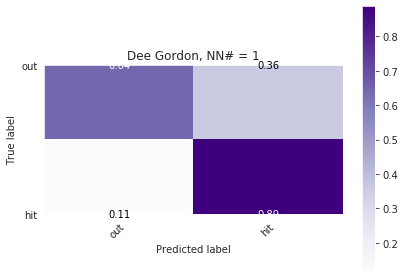

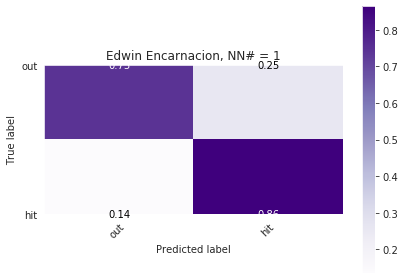

Normalized confusion matrix
[[0.85714286 0.14285714]
 [0.16981132 0.83018868]]
Normalized confusion matrix
[[0.84313725 0.15686275]
 [0.2012987  0.7987013 ]]


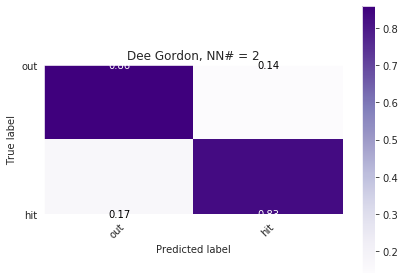

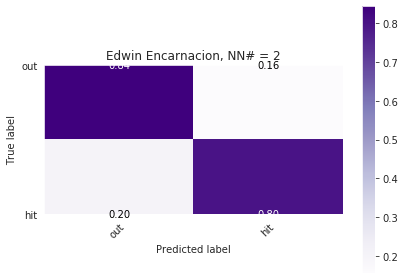

Normalized confusion matrix
[[0.61904762 0.38095238]
 [0.06603774 0.93396226]]
Normalized confusion matrix
[[0.7254902  0.2745098 ]
 [0.07792208 0.92207792]]


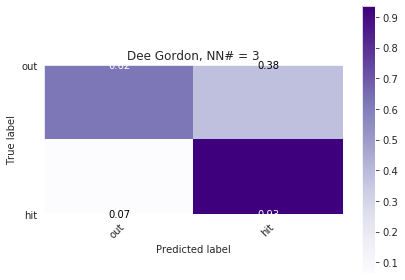

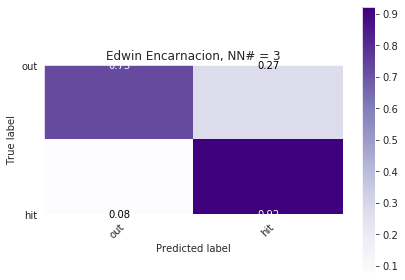

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.10377358 0.89622642]]
Normalized confusion matrix
[[0.76470588 0.23529412]
 [0.11688312 0.88311688]]


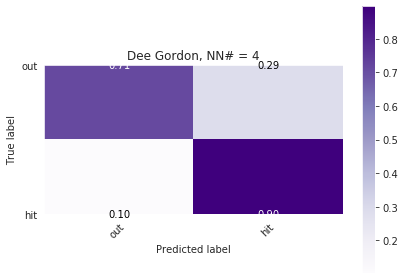

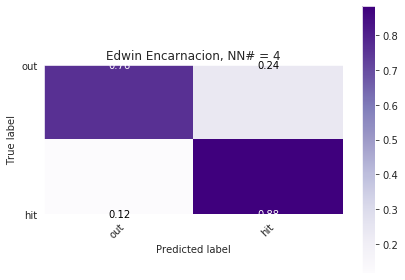

Normalized confusion matrix
[[0.57142857 0.42857143]
 [0.04716981 0.95283019]]
Normalized confusion matrix
[[0.70588235 0.29411765]
 [0.07792208 0.92207792]]


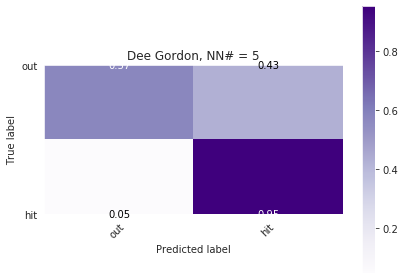

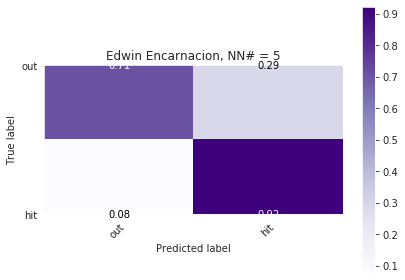

Normalized confusion matrix
[[0.69047619 0.30952381]
 [0.0754717  0.9245283 ]]
Normalized confusion matrix
[[0.78431373 0.21568627]
 [0.0974026  0.9025974 ]]


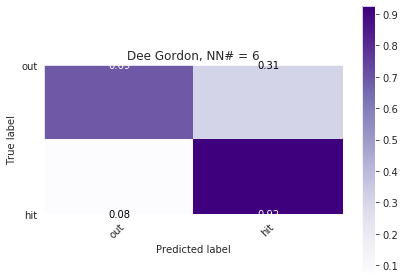

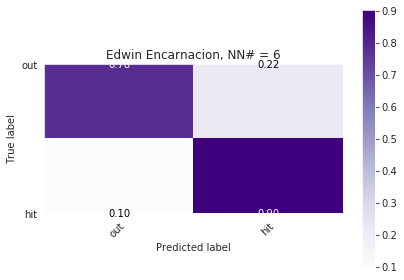

Normalized confusion matrix
[[0.61904762 0.38095238]
 [0.04716981 0.95283019]]
Normalized confusion matrix
[[0.68627451 0.31372549]
 [0.06493506 0.93506494]]


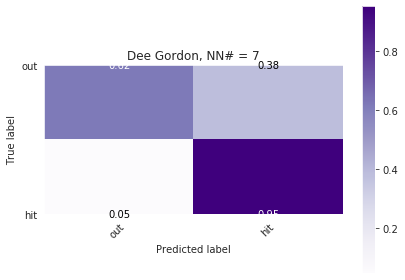

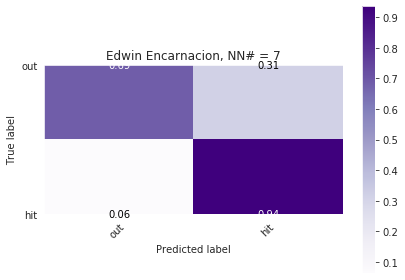

Normalized confusion matrix
[[0.64285714 0.35714286]
 [0.0754717  0.9245283 ]]
Normalized confusion matrix
[[0.80392157 0.19607843]
 [0.07792208 0.92207792]]


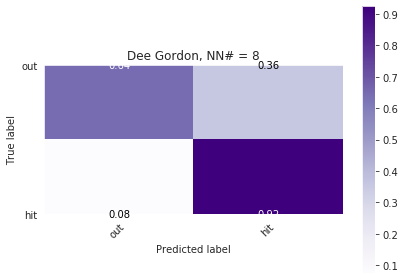

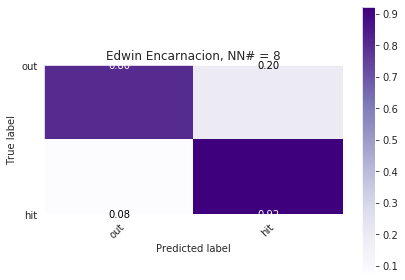

Normalized confusion matrix
[[0.61904762 0.38095238]
 [0.02830189 0.97169811]]
Normalized confusion matrix
[[0.7254902  0.2745098 ]
 [0.06493506 0.93506494]]


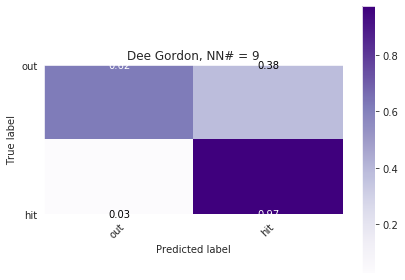

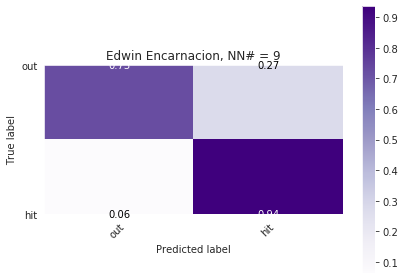

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.04716981 0.95283019]]
Normalized confusion matrix
[[0.78431373 0.21568627]
 [0.09090909 0.90909091]]


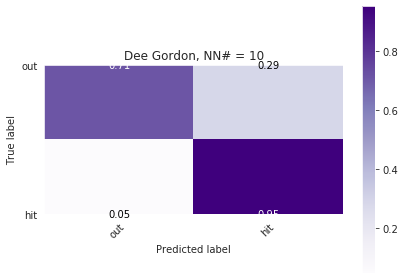

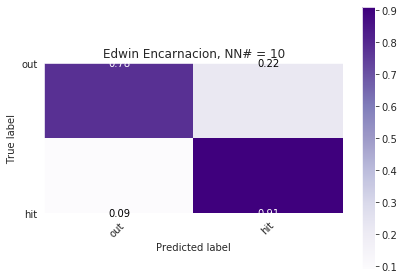

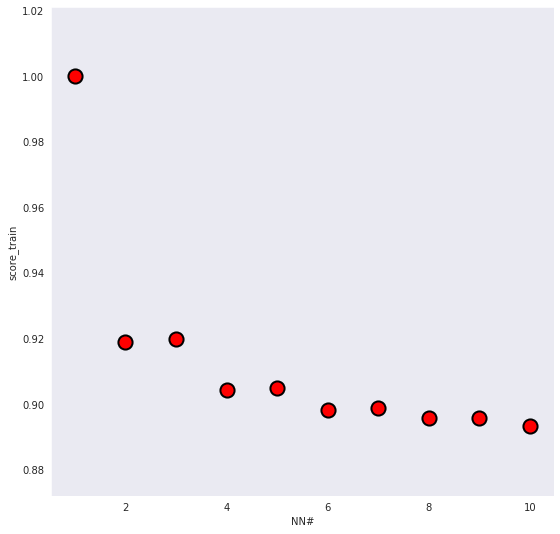

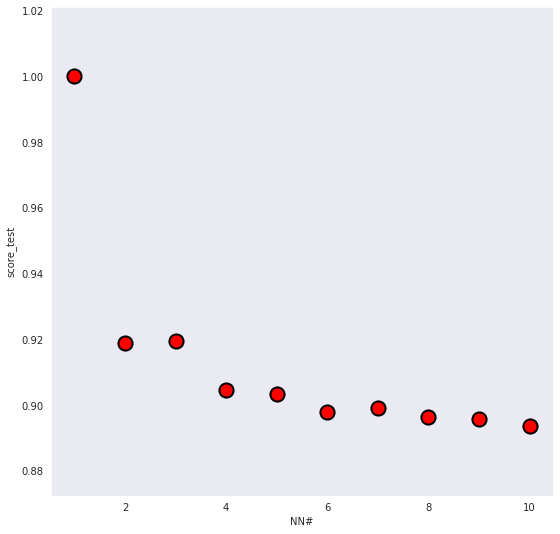

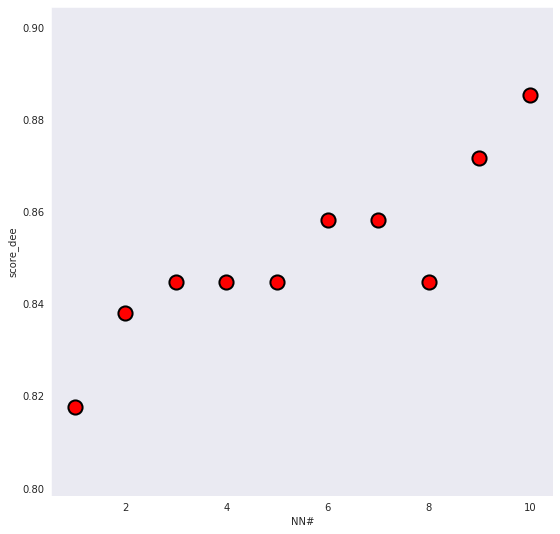

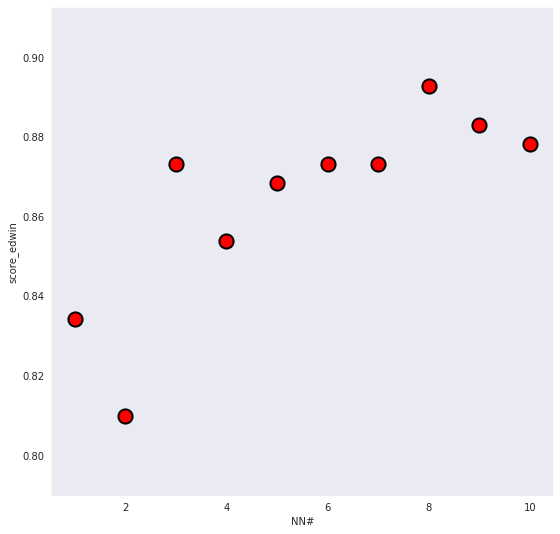

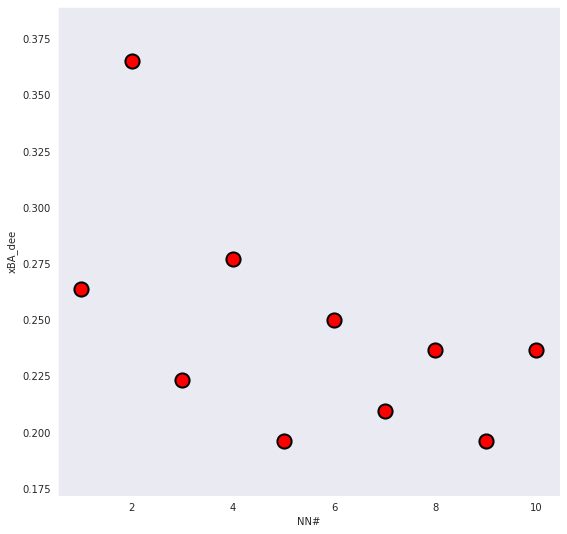

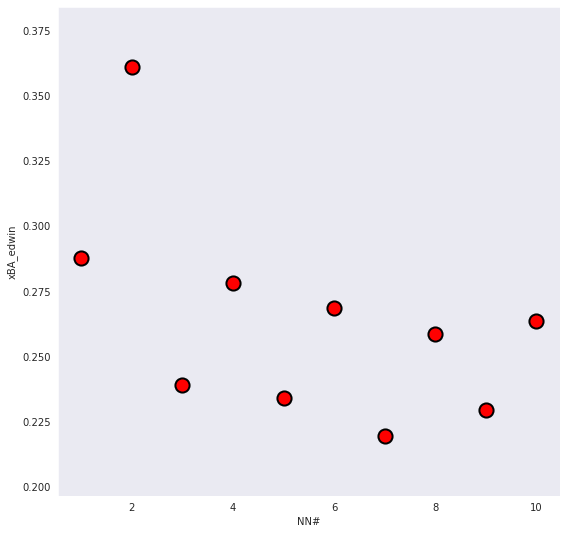

In [8]:
# split up data into train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 0
)

nn_dict = {}
for nn in range(1, 11):
    # K-Nearest Neighbors 
    clf = neighbors.KNeighborsClassifier(nn)
    clf.fit(X, y)
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    
    # calculate expected batting average for a couple players
    dee = pd.read_csv('data/dee_gordon_2019.csv')
    edwin = pd.read_csv('data/edwin_encarnacion.csv')
    
    X_dee, y_dee, df_dee = pre_process(dee)
    X_edwin, y_edwin, df_edwin = pre_process(edwin)
    
    predicted_outcomes_dee = clf.predict(X_dee)
    unique, counts = np.unique(predicted_outcomes_dee, return_counts=True)
    d = dict(zip(unique, counts))
    xBA_dee = d['hit']/(d['out'] + d['hit'])
    
    predicted_outcomes_edwin = clf.predict(X_edwin)
    unique, counts = np.unique(predicted_outcomes_edwin, return_counts=True)
    d = dict(zip(unique, counts))
    xBA_edwin = d['hit']/(d['out'] + d['hit'])
    
    score_dee = clf.score(X_dee, y_dee)
    score_edwin = clf.score(X_edwin, y_edwin)
    nn_dict[nn] = [score_train, score_test, score_dee, score_edwin, xBA_dee, xBA_edwin]
    
    
    sns.set_style('dark')
    plot_confusion_matrix(
        y_dee, predicted_outcomes_dee, ['out', 'hit'],
        normalize=True, title='Dee Gordon, NN# = ' + str(nn)
    )
    plot_confusion_matrix(
        y_edwin, predicted_outcomes_edwin, ['out', 'hit'],
        normalize=True, title='Edwin Encarnacion, NN# = ' + str(nn)
    )
    plt.show()

nn_df = pd.DataFrame.from_dict(nn_dict, orient='index')
nn_df.columns = ['score_train', 'score_test', 'score_dee', 'score_edwin', 'xBA_dee', 'xBA_edwin']

for col in nn_df:
    fig, ax = plt.subplots(figsize=(9,9))
    ax.scatter(
        nn_df.index, nn_df[col], s=200, c='red',
        edgecolors='black', linewidth=2,
    )
    ax.set_xlabel('NN#')
    ax.set_ylabel(col)
    fig.savefig('plots/nn_test_1-10_' + col + '.png', dpi=300)

Working on NN = 201 ...


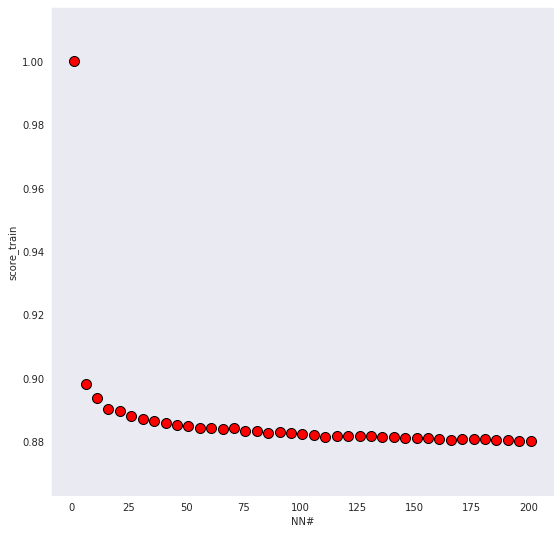

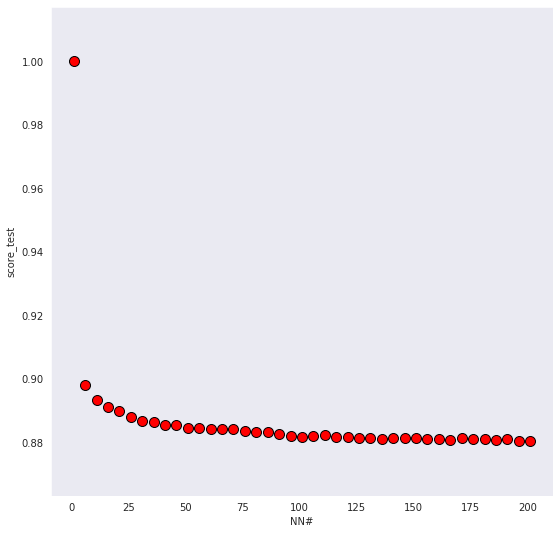

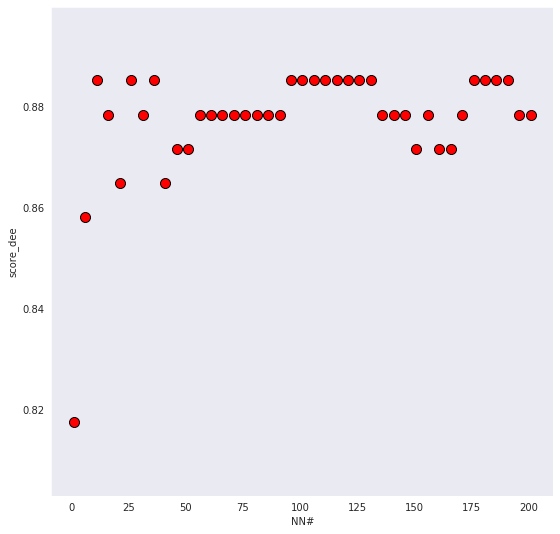

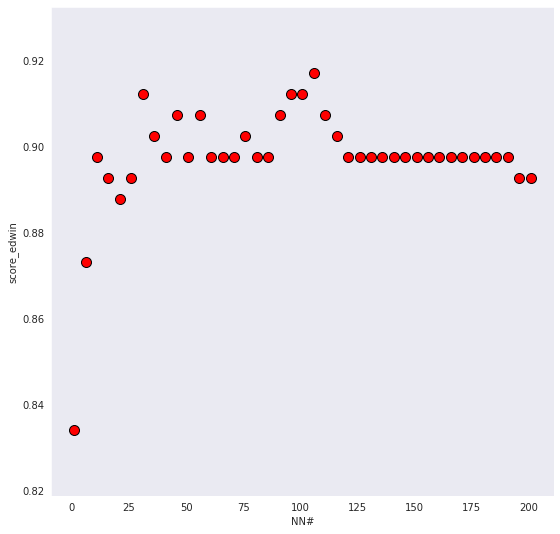

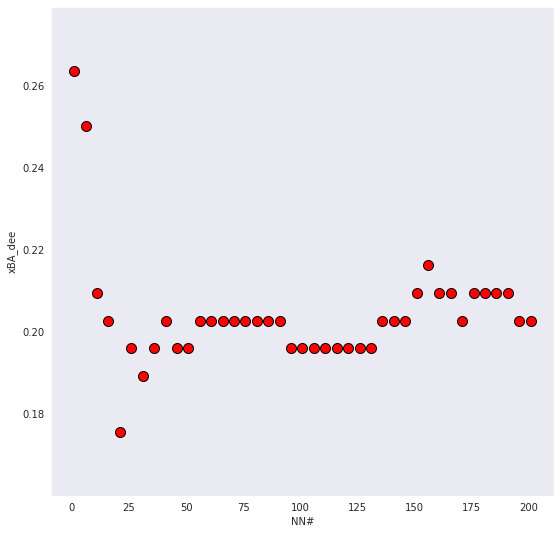

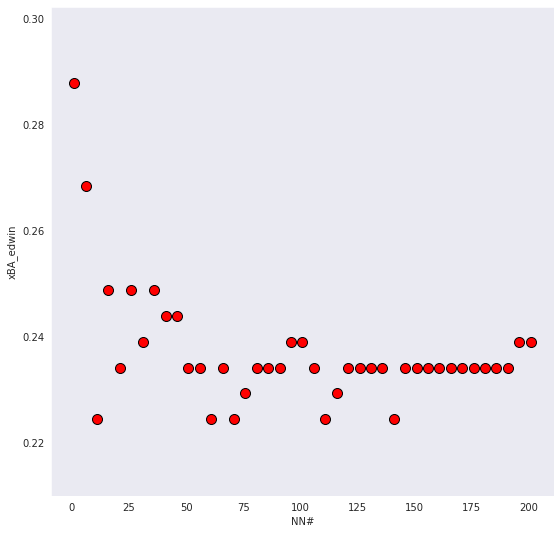

In [9]:
# split up data into train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 0
)

nn_dict = {}
# for nn in range(1, 1002, 10):
for nn in range(1, 202, 5):
    clear_output()
    print('Working on NN = ' + str(nn) + ' ...')
    # K-Nearest Neighbors 
    clf = neighbors.KNeighborsClassifier(nn)
    clf.fit(X, y)
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    
    # calculate expected batting average for a couple players
    dee = pd.read_csv('data/dee_gordon_2019.csv')
    edwin = pd.read_csv('data/edwin_encarnacion.csv')
    
    X_dee, y_dee, df_dee = pre_process(dee)
    X_edwin, y_edwin, df_edwin = pre_process(edwin)
    
    predicted_outcomes_dee = clf.predict(X_dee)
    unique, counts = np.unique(predicted_outcomes_dee, return_counts=True)
    d = dict(zip(unique, counts))
    xBA_dee = d['hit']/(d['out'] + d['hit'])
    
    predicted_outcomes_edwin = clf.predict(X_edwin)
    unique, counts = np.unique(predicted_outcomes_edwin, return_counts=True)
    d = dict(zip(unique, counts))
    xBA_edwin = d['hit']/(d['out'] + d['hit'])
    
    score_dee = clf.score(X_dee, y_dee)
    score_edwin = clf.score(X_edwin, y_edwin)
    nn_dict[nn] = [score_train, score_test, score_dee, score_edwin, xBA_dee, xBA_edwin]

nn_df = pd.DataFrame.from_dict(nn_dict, orient='index')
nn_df.columns = ['score_train', 'score_test', 'score_dee', 'score_edwin', 'xBA_dee', 'xBA_edwin']

for col in nn_df:
    fig, ax = plt.subplots(figsize=(9,9))
    ax.scatter(
        nn_df.index, nn_df[col], s=100, c='red',
        edgecolors='black', linewidth=1,
    )
    ax.set_xlabel('NN#')
    ax.set_ylabel(col)
    fig.savefig('plots/nn_test_1-202_' + col + '.png', dpi=300)

- Looks like NN# = ~105 is a good compromise

#### Notes

- Overfitting issue seems to improve with larger N
    - Obviously NN=1 is extreme
- Dee's fit score goes up with NN, but edwin's drops...
    - Looking for a compromise in the 10-200 range
- We have >100,000 data points, so even NN=1000 isn't super unreasonable..

## Defining xBABIP+ and BAASH

- Borrowing from general sabermetric nomenclature:
    - "x" denotes "expected"
    - "+" denotes normalization such that league average is 100, and 110 is 10% better than average
- An expected BABIP could be league average BABIP, then xBABIP+ would be BABIP - league_avg(BABIP) --> normalize to 100
    - This doesn't separate the three main types of players that might have higher than avg BABIP
        1. Players who hit the ball *really* hard
        2. Players who are fast
        3. Player who are lucky
    - OK, so we can't really sort out the lucky players, but we can sort out the hard hitters from the fast runners...
- By calculated xBABIP using a model and a players launch speed, angle, and spray angle, we account for the hard hitter
    - If a hitter it always either striking out or mashing the ball, their BABIP would be pretty high, but their **predicted** BABIP based on statcast data would account for this
    - Now, the players that don't mash the ball but are fast will have relatively lower predicted BABIP, but a higher actual BABIP 
- Thus, xBABIP+ is more of a speed and hustle stat (note: "hustle" has some problems...)
- Let's give it it's own jargon: **BAASH** 
    - Batting Average Added from Speed and Hustle
    - we could normalize to BAASH+, but it's probably more intuitive to stay in units of BA
- Now, we have an ironically named stat for speed!

## xBA Rankings for 2019

In [10]:
# remove players with fewer than 100 ABs
data2019 = pd.read_csv('data/all_outcomes_2019.csv')
AB100 = []
for pid in data2019['batter'].unique():
    if data2019.loc[data2019['batter'] == pid].shape[0] >= 100 and pid not in AB100:
        AB100.append(pid)


# length of AB100 is 195
cBA, xBA = [], []
xBAd = {}
for i, pid in enumerate(AB100):
    clear_output()
    print('Processing {:d}/{:d}'.format(i+1, len(AB100)) + ' Player IDs...')
    pdata = data2019.loc[data2019['batter'] == pid].copy()
    Xp, yp, dfp = pre_process(pdata)
    predicted_outcomes = clf.predict(Xp)
    unique, counts = np.unique(predicted_outcomes, return_counts=True)
    d = dict(zip(unique, counts))
    xBA = d['hit']/(d['out'] + d['hit'])
    
    cBA = calc_BA(pdata)
    xBAd[pid] = [round(cBA, 3), round(xBA, 3)]

Processing 304/304 Player IDs...


## Process xBA Results

In [11]:
import pybaseball as pbb
pd.set_option('display.max_columns', 100)
# convert to dataframe
results = pd.DataFrame.from_dict(xBAd, orient='index')
results.columns = ['cBA', 'xBA']
results.index.name = 'mlb_id'

# match player_id to player name
# map from http://crunchtimebaseball.com/baseball_map.html
# current as of 9 June 2019
id_map = pd.read_csv('data/player_id_map.csv', encoding='Latin-1', index_col='fg_name')
# keep only the info we might use later
id_map = id_map[['mlb_id', 'mlb_name', 'fg_id']]
# import fangraphs batting data from 2019
fg_batting = pd.read_csv('data/FanGraphs_Leaderboard_2019.csv')
fg_batting = fg_batting.sort_values('Name') \
                        .rename(columns = {'Name': 'fg_name'}) \
                        .join(id_map, on='fg_name', how='left') \
                        .set_index('mlb_id', drop=True).drop(['playerid', 'fg_id', 'fg_name'], axis=1) \
                        .rename(columns = {'mlb_name': 'Name'})

cols = [fg_batting.columns.tolist()[-1], *fg_batting.columns.tolist()[:-1]]
fg_batting = fg_batting[cols]
# join results and fg_batting
results = fg_batting.join(results, on='mlb_id', how='left').dropna()
results.sort_values(by='xBA', inplace=True, ascending=False)
results['diff'] = results['AVG'] - results['xBA']
results.head()

# get statcast's expected results
expected_sc = pd.read_csv('data/expected_stats.csv', index_col='player_id')
expected_sc.index.name = 'mlb_id'
expected_sc = expected_sc[[
    'est_ba', 'est_ba_minus_ba_diff', 'est_slg', 'est_woba',
    'est_slg_minus_slg_diff', 'est_woba_minus_woba_diff'
]]
results = results.join(expected_sc, how='left')
speed = pd.read_csv('data/sprint_speed.csv', index_col='player_id')
speed.index.name = 'mlb_id'
speed = speed[['hp_to_1b', 'sprint_speed']]
results = results.join(speed, how='left')
results.to_csv('data/xBA_leaderboard_plus_fg_sc.csv', index=False)
results.head()

ModuleNotFoundError: No module named 'pybaseball'

In [ ]:
select = results[[
    'Name', 'PA', 'HR', 'R', 'RBI', 'SB', 'K%',
    'OBP', 'SLG', 'wOBA', 'WAR', 'BABIP', 'cBA', 'AVG',
    'xBA', 'est_ba', 'diff', 'est_ba_minus_ba_diff',
    'hp_to_1b', 'sprint_speed'
]]
select = select.rename(
    columns={'est_ba': 'xBA_sc', 'est_ba_minus_ba_diff': 'diff_sc'}
)
select = select.sort_values('diff', ascending=False)
select.head(25)

In [ ]:
from scipy.stats import linregress

for col in select._get_numeric_data():
    nanbool = select[col].notnull()
    # x = select['diff'][nanbool]
    x = (select['xBA'] - select['xBA_sc'])[nanbool]
    y = select[col][nanbool]
    slope, intercept, rvalue, pvalue, stderr = linregress(x, y)
    fig, ax = plt.subplots(figsize=(9,9))
    ax.scatter(x, y, s=50, c='m', edgecolors='black', linewidth=1.5, alpha=0.75)
    ax.plot(x, slope*x + intercept, color='gray', linestyle='-', linewidth=1)
    ax.text(0.05, 0.95, r'$R^2$: %f      p-value: %f' % (rvalue, pvalue), transform=ax.transAxes)
    # ax.set_xlabel('diff')
    ax.set_xlabel('xBA - xBA_sc')
    ax.set_ylabel(col)
    ax.set_title(col)
        

#### Notes

- Seems like players where xBA > xBA_sc is True are generally slower power hitters.
    - Statcast must factor in player speed in their xBA calcs

In [ ]:
select['diff_diff'] = select['xBA'] - select['xBA_sc']
select.sort_values('diff_diff', ascending=False)
select